<a href="https://colab.research.google.com/github/sbh69840/SOT/blob/main/Object_tracking_opencv_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object tracking using OpenCV 
A simple object tracker built with OpenCV and JavaScript (for selecting the bounding box) \\
This tutorial is for any video, just replace the name of the video from the name of the file that you want to run the algorithm on.

In [1]:
# To execute some of the system commands like unzip and cp
import os
# Image processing library which contains trackers and image manipultation tools
import cv2
# Disply widgets to show output on the cell 
from IPython.display import HTML, Image
# Communicate between JS and Python
from google.colab.output import eval_js
# To display images because cv2.imshow doesn't work as it opens a new X-terminal
# which is not possible because a jupyter notebook instance doesn't allow that
from google.colab.patches import cv2_imshow
# To convert images to GIF
from PIL import Image
# high-level mathematical functions library
import numpy as np

In [2]:
# Clone the repository containing the dataset collected for the purpose of object tracking
!git clone https://github.com/sbh69840/SOT-dataset.git

Cloning into 'SOT-dataset'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 8), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [3]:
# Resource : https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/

# List of available trackers in openCV
tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
# Function used to select tracker
def select_tracker(tracker_id):
  # Make tracker and tracker_type global to access it outside the function
  global tracker
  global tracker_type
  tracker_type = tracker_types[tracker_id]
  # Set up tracker.
  if tracker_type == 'BOOSTING':
      tracker = cv2.TrackerBoosting_create()
  if tracker_type == 'MIL':
      tracker = cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      tracker = cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      tracker = cv2.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      tracker = cv2.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      tracker = cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      tracker = cv2.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      tracker = cv2.TrackerCSRT_create()

In [4]:
# Call the function to select the tracker
select_tracker(0)
# Print to check the name of the tracker
print(tracker)

<TrackerBoosting 0x7f122d972ad0>


# Open the hidden cell to upload a file from your device

In [ ]:
#@title Open to upload file

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [5]:
# Change the name of the file to the one that you have uploaded if needed
video = cv2.VideoCapture("SOT-dataset/videoplayback (2).mp4")
# get the width and height of the frame
frame_width = int(video.get(3))
frame_height = int(video.get(4))
# Output writer used to make a MP4 video
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10, (frame_width,frame_height))
# get the first frame of the video
ok, frame = video.read()
# write the first frame, we could write the frame after adding the bounding box 
# because this one doesn't contain one but since the rest of the frames do have it
# I was too lazy to add the frame after drawing bounding box
out.write(frame)
# Save the first frame in this location to access it inside of HTML
cv2.imwrite('/usr/local/share/jupyter/nbextensions/first_frame.png',frame)

True

In [6]:
html_canvas = """
<!--
Create the canvas to display the image to mark the bounding box. 
-->
<canvas id="canvas"></canvas>
<!--
Button used to send the bounding box coordinates  
-->
<button id="capture">Capture</button>
<script>
<!--
//Canvas to draw the bounding box on 
-->
var canvas = document.getElementById('canvas');
<!--
//Width of the image 
-->
var width = %d;
<!--
//Height of the image 
-->
var height = %d;
<!--
//Set canvas width to the width of the image 
-->
canvas.style.width = width+'px';
<!--
//Set canvas height to the height of the image 
-->
canvas.style.height = height+'px';
<!--
//Get context of the canvas used to draw on the images
-->
var ctx = canvas.getContext('2d');
<!--
//Set context width and height according to image width and height
-->
ctx.canvas.width = width;
ctx.canvas.height = height;
<!--
//Load the image onto a image class to draw it on a canvas
-->
var base_image = new Image();
base_image.src = '%s';
base_image.width = width+'px';
base_image.height = height+'px';
base_image.onload = function(){
  ctx.drawImage(base_image,0,0,width,height);
}
<!--
//Call the function that keeps track of the mouse events and draws bounding boxes
-->
initDraw(canvas,ctx);
<!--
//Global variables used to send the coordinates that will be set in inside the function 
//initDraw(canvas,ctx)
-->
var x,y,width,height;
function initDraw(canvas,ctx) {
    <!--
    //function used to set the mouse position according to current position
    -->
    function setMousePosition(e) {
        var ev = e || window.event; //Moz || IE
        if (ev.pageX) { //Moz
            mouse.x = ev.pageX + window.pageXOffset;
            mouse.y = ev.pageY + window.pageYOffset;
        } else if (ev.clientX) { //IE
            mouse.x = ev.clientX + document.body.scrollLeft;
            mouse.y = ev.clientY + document.body.scrollTop;
        }
    };
    <!--
    //Dictionary used to store current x, current y position when the mouse moves
    //and also startX and startY to store the left corner point on first click
    -->
    var mouse = {
        x: 0,
        y: 0,
        startX: 0,
        startY: 0
    };
    <!--
    //local left, top, width and height used to keep track of bounding box inside
    //of this function
    -->
    var left=null,top=null,width=0,height=0;
    <!--
    //Function called when the mouse pointer is moved
    -->
    canvas.onmousemove = function (e) {
        <!--
        //set current position to the position of the mouse pointer on screen
        -->
        setMousePosition(e);
        <!--
        //check if left is null, if it is then there is no rectangle on the screen
        -->
        if (left !== null) {
            <!--
            //This will clear the entire canvas whenever there is already a rectangle 
            //on the screen because we only need one rectangle on the screen at 
            //a given time
            -->
            ctx.clearRect(0,0,canvas.width,canvas.height);
            <!--
            //After clearing the whole canvas the image will no longer be there
            //so draw it again
            -->
            ctx.drawImage(base_image,0,0,canvas.width,canvas.height);
            <!--
            //Set width, height, top, left values with respect to the startX
            //and startY positions
            -->
            width = Math.abs(mouse.x - mouse.startX);
            height = Math.abs(mouse.y - mouse.startY);
            left = (mouse.x - mouse.startX < 0) ? mouse.x : mouse.startX;
            top = (mouse.y - mouse.startY < 0) ? mouse.y : mouse.startY;
            <!--
            //Init function before drawing on canvas
            -->
            ctx.beginPath();
            <!--
            //Set the width of the line, strokecolor as per the user input
            -->
            ctx.lineWidth = "%d";
            ctx.strokeStyle = "%s";
            ctx.strokeRect(left, top, width, height);
            <!--
            //console.log(left,top,width,height);
            -->
            ctx.stroke();
        }
    }
    <!--
    // Invoke onclick function when clicked on canvas 
    -->
    canvas.onclick = function (e) {
      <!--
      // if left is null that means the rectangle is not there and you create
      // a new one by assigning startX and startY else assign coordinate values
      // of the rectangle according to current position of the mouse pointer
      -->
        if (left !== null) {
            window.x = left;
            window.y = top;
            window.width = width;
            window.height = height;
            left = null;
            canvas.style.cursor = "default";
            console.log("finsihed.");
        } else {
            console.log("begun.");
            mouse.startX = mouse.x;
            mouse.startY = mouse.y;
            left = mouse.x;
            top = mouse.y;
            canvas.style.cursor = "crosshair";
        }
    }
    
    
}
<!--
//Get the button from the document and send the coordinates to python using
//promise when the button is clicked
-->
var button = document.getElementById('capture');
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve([x,y,width,height]);
  }
});
</script>
"""

# Fuction used to create the html page in the cell and receive whatever data will
# be sent from the variable data in the javascript code above
# Return: tuple of (x, y, width, height) bounding box
def selectROI(filename='1.jpg', w=400, h=200, line_width=3,color="yellow"):
  display(HTML(html_canvas%(w,h,'/nbextensions/{}'.format(filename),line_width,color)))
  data = eval_js("data")
  return tuple(data)

In [7]:
# Get the bounding box
bbox = selectROI("first_frame.png",frame.shape[1],frame.shape[0],3,"yellow")

In [8]:
bbox

(8, 106, 213, 167)

In [9]:
# Initialize the tracker with the first frame
ok = tracker.init(frame,bbox)

In [10]:
print(ok)

True


In [11]:
gif = [frame]

In [12]:
while True:
  # clear_output()
  ok, frame1 = video.read()
  if not ok:
    break
  
  # Start timer
  timer = cv2.getTickCount()
  # Update the tracker
  ok, bbox = tracker.update(frame1)

  # Calculate Frames Per Second (FPS) 
  fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

  if ok:
    # Tracking success
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame1, p1, p2, (0,255,255), 3, 1)
  else:
    # Tracking failure
    cv2.putText(frame1, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(255,0,0),2)
  
  # Display tracker type on frame
  cv2.putText(frame1, tracker_type + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255),2)
  
  # Display FPS on frame
  cv2.putText(frame1, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 2)
  # Write the frame with bounding box to the output video writer
  out.write(frame1)
  gif.append(frame1)
  # cv2_imshow(frame)
# Close the input video stream 
video.release()
# Close the output video writer
out.release()

In [13]:
# Resource: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [14]:
import random
random.seed(10)
n = len(gif)
ind = set(random.sample(list(range(0,n)),12))
cur_image_ind = 0
cur_ind = 0
imgs = [[] for _ in range(3)]
for image in gif:
  if cur_image_ind in ind:
    imgs[cur_ind%3].append(image_resize(image,200))
    cur_ind+=1
  cur_image_ind+=1

In [15]:
for i in range(3):
  imgs[i] = np.hstack(imgs[i])
v_stack = np.vstack(imgs)


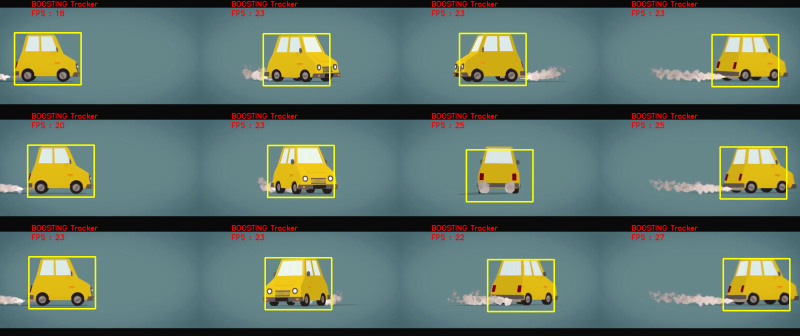

In [16]:
cv2_imshow(v_stack)